# Evaluation metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?

## 4.1 Evaluation metrics: session overview

- Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
- https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style

style.use('seaborn')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv('data-week-3.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [5]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [7]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## 4.2 Accuracy and dummy model

- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

$$ Accuracy = \frac{Correct Predictions}{N Samples}

In [8]:
len(y_val)

1409

In [10]:
correct = (y_val == churn_decision).sum()
correct

1132

In [11]:
print(f"Accuracy {correct/len(y_val)}")

Accuracy 0.8034066713981547


What if we change the decision threshold?

In [28]:
from sklearn.metrics import accuracy_score

In [29]:
thresholds = np.linspace(0,1,21)
scores = []
for thr in thresholds:
    churn_decision = (y_pred >= thr)
    score = accuracy_score(y_val,churn_decision)
    scores.append(score)

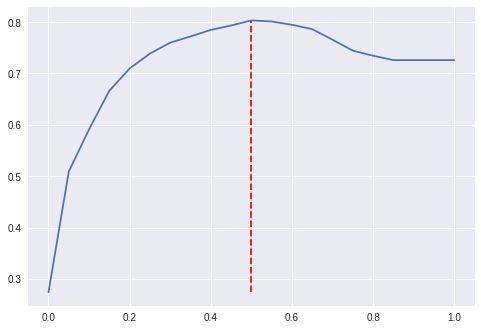

In [31]:
max_score_idx = scores.index(max(scores))
plt.plot(thresholds,scores)
plt.vlines(x=thresholds[max_score_idx],ymin=min(scores),ymax=max(scores),color='r',ls='--')

The accuracy of the predictions using a threshold of 1, we see that the accuracy is quite high (~0.73). But why is that?

In [32]:
from collections import Counter

In [35]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

If we look at the distribution of y_val, we see that there are a lot more non-churning users. We see that ~27% of the users are churning. If we predict everything as non-churning, we will have a high accuracy. The model is only incorrect for the cases where the users are churning (~27%). This problem is refered to class imbalance. Thus, accuracy is not the best metric for problems where we find that the classes are imbalanced.

In [37]:
Counter(y_val)

Counter({0: 1023, 1: 386})

In [36]:
1 - y_val.mean()

0.7260468417317246

## 4.3 Confusion table

- Different types of errors and correct decisions
- Arrange them in a table

In [38]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [39]:
threshold = 0.5
pred_positive = (y_pred >= threshold)
pred_negative = (y_pred < threshold)

In [41]:
(actual_positive & pred_positive)[:5]

array([False, False, False,  True, False])

In [44]:
true_positive = (actual_positive & pred_positive).sum()
true_negative = (actual_negative & pred_negative).sum()

print(f"tp ={true_positive}, tn ={true_negative}")

tp =210, tn =922


In [45]:
false_positive = (pred_positive & actual_negative).sum()
false_negative = (pred_negative & actual_positive).sum()

print(f"fp = {false_positive}, fn = {false_negative}")

fp = 101, fn = 176


| Actual/Predictions | Negative | Positive |
|-------------|----------|----------|
| Negative    | TN = 922      | FP  = 101      |
| Positive    | FN = 176      | TP  = 210     |


In [47]:
confusion_matrix = np.array([
    [true_negative,false_positive],
    [false_negative,true_positive]
])

In [48]:
confusion_matrix

array([[922, 101],
       [176, 210]])

In [52]:
norm_confusion_matrix = np.round(confusion_matrix / confusion_matrix.sum(),2)
norm_confusion_matrix

array([[0.65, 0.07],
       [0.12, 0.15]])

$$Accuracy = tn + tp$$

## 4.4 Precision and Recall 

Metris to evaluate binary classification models.

Precision: Fraction of positive predictions that are correct. $$precision = \frac{Tp}{Tp+Fp}$$

Recall: Fraction of correctly identified positive examples. We are interested in the actual positive points. $$recall=\frac{Tp}{NumPositiveobs}=\frac{Tp}{Tp+Fn}$$

Approx 33% of positive predictions are actually negative. (1-precision)

In [54]:
precision = true_positive/(true_positive+false_positive)
precision

0.6752411575562701

The model failed identifying 46% of people churning (actual positive)

In [65]:
recall = true_positive/(true_positive+false_negative)
recall

0.5440414507772021

## 4.5 ROC Curves

ROC = Receiver operating characteristic

